# Canopy Radiative Transfer Example #1
This example will go through the calculations of hemispheric and bidirectional reflectance as well as emission of Solar Induced Chlorophyll Fluorescence (SIF). The sun sensor geometry is defined by the solar zenith angle SZA, the viewing zenith angle VZA (observer, 0degrees=Nadir looking) and the relative azimuth angle between the sun and observer (0 or 180degrees denoting the principal plane).

In [1]:
# Use Julia Plots package and switch to plotly js option:
using PyPlot

┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/runner/.julia/packages/PyCall/zqDXB/src/PyCall.jl:697
┌ Info: Running `conda install -q -y matplotlib` in root environment
└ @ Conda /Users/runner/.julia/packages/Conda/3rPhK/src/Conda.jl:113
Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/runner/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py37_0          14 KB
    freetype-2.10.2            |       ha233b18_0         570 KB
    kiwisolver-1.2.0           |   py37h04f5b5a_0          55 KB
    libpng-1.6.37              |       ha441bb4_0         262 KB
    matplotlib-3.2.2           |                0          21 KB
    matplotlib-base-3.2.2      |   py37h5670ca0_0         5.4 MB
    pyparsing-2.4.7            

First, we include Revise (good for debugging) and Parameters (tools for structures)

In [2]:
#using Revise
using Parameters

Now include the Land modules

In [3]:
using Land
using Land.CanopyRT

and unpack some of the mostly used variables or structure (same as writing CanopyRT.leafbio)

In [4]:
#@unpack FT, leafbio, canopy, angles, canOpt, canRad,sunRad,soil, wl, wle, wlf = CanopyRT

This extracted a number of structures, which are loaded with default values at startup:
* *leafbio* includes all leaf pigment concentrations, such as Chlorophyll, leaf water, Carotenoids and dry matter content. (mutable struct leafbio)
* *canopy* includes Canopy properties such as LAI, leaf inclination distribution, clumping factor (mutable struct struct_canopy)
* *angles* includes SZA, VZA and azimuth (mutable struct struct_angles)
* *canOpt* saves a variety of canopy optical properties to be computed (mutable struct struct_canopyOptProps)
* *canRad* includes radiation computed within the Canopy RT module (mutable struct struct_canopyRadiation)
* *sunRad* provides incoming direct and diffuse incoming solar radiation (mutable struct incomingRadiation)
* *soil* provides soil albedo and skin temperature

as well as some arrays:
* *wl* is the wavelength grid (nm) for the solar radiation computation
* *wle* is the wavelength grid in the photosynthetically active range (a subset of wl, used to define fluorescence excitation and driving photosynthesis)
* *wlf* is the wavelength grid for SIF (subset of wl). The fluorescence excitation matrices are defined on the basis of wle and wlf.

Let us just define our own leaf here, we can construct it using standard values but need to provide all dimensions (will be fixed as variables are saved in MArrays):

In [5]:
const FT = Float32

wl_set = create_wl_para_set(FT)
leaf = create_leaf_bio(FT, wl_set.nwl, wl_set.nWlE, wl_set.nWlF);
canopy_rt = Canopy4RT{FT, 20, 3.0}()
canRad_rt = CanopyRadiation{FT, wl_set.nwl, wl_set.nWlF, length(canopy_rt.litab), length(canopy_rt.lazitab), canopy_rt.nlayers}()
canOpt_rt = create_canopy_optical(FT, wl_set.nwl, canopy_rt.nlayers, length(canopy_rt.lazitab), length(canopy_rt.litab); using_marray=false)
sunRad_rt = create_incoming_radiation(FT, wl_set.swl);

# show leaf Chlorophyll content:
@show leaf.Cab

leaf.Cab = 40.0f0


40.0f0

---
## Leaf Optical Properties

Now we can first run fluspect, which is an extension of the Prospect leaf optical properties program and includes computations of the fluorescence emission responses as well. CanopyRT.optis includes all pigment absorption cross sections as well as refractive index of water to compute leaf optical properties.
For details, see:

Féret, J.B., Gitelson, A.A., Noble, S.D. and Jacquemoud, S., 2017. PROSPECT-D: Towards modeling leaf optical properties through a complete lifecycle. Remote Sensing of Environment, 193, pp.204-215.

Van der Tol, C., Verhoef, W., Timmermans, J., Verhoef, A. and Su, Z., 2009. An integrated model of soil-canopy spectral radiances, photosynthesis, fluorescence, temperature and energy balance. Biogeosciences, 6(12).

Vilfan, N., Van der Tol, C., Muller, O., Rascher, U. and Verhoef, W., 2016. Fluspect-B: A model for leaf fluorescence, reflectance and transmittance spectra. Remote sensing of environment, 186, pp.596-615.

In [6]:
# Run Fluspect:
fluspect!(leaf, wl_set);

#### Fluorescence excitation matrices
Now we can visualize the fluorescence excitatiom matrices, which determine how absorbed photons at a specific wavelength *wle* incident on the leaf are emitted backwards (in relation to the incident light but hemispherically diffuse here) or forward. Here, we ignore contributions from Photosystem I and just use a fixed shape as input at the chloroplast level for Photosystem II, hence all spectral shapes are determined by the light distribution within the leaf. Several effects can be observed in the plots below: The first SIF peak at 680nm is much weaker in the forward direction than in the backward direction as more the re-absorption within the leaf is much higher for the forward direction. Similarly, blue incident light penetrates the leaf less than at higher wavelengths, so the chlorophyll re-absorption (backwards) is less re-absorbed by chlorophyll as it emanates from less deep layers.

Unable to create basic Accelerated OpenGL renderer.
Unable to create basic Accelerated OpenGL renderer.
Core Image is now using the software OpenGL renderer. This will be slow.


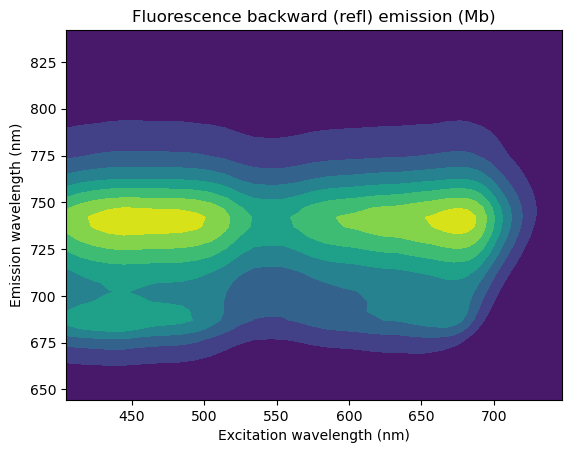

In [7]:
# Plot Mb matrix
figure()
contourf(wl_set.wle, wl_set.wlf, leaf.Mb)
xlabel("Excitation wavelength (nm)")
ylabel("Emission wavelength (nm)")
title("Fluorescence backward (refl) emission (Mb)")
gcf()

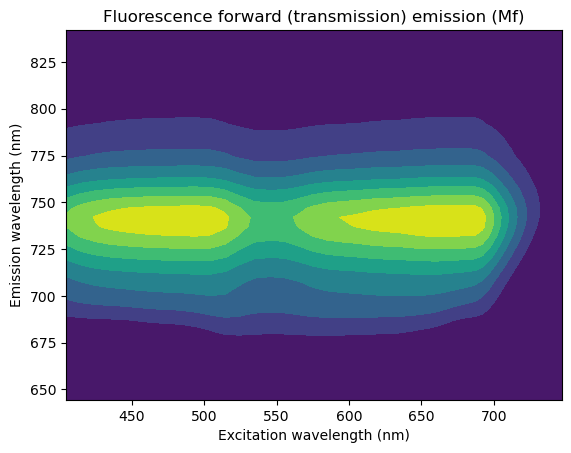

In [8]:
# Plot Mf matrix
figure()
contourf(wl_set.wle, wl_set.wlf, leaf.Mf)
xlabel("Excitation wavelength (nm)")
ylabel("Emission wavelength (nm)")
title("Fluorescence forward (transmission) emission (Mf)")
gcf()

In [9]:
# Define a few wavelengths:
wl_blue = 450.0;
wl_red = 600.0;
wl_FarRed = 740.0;
wl_Red = 685.0;
ind_wle_blue  = argmin(abs.(wl_set.wle .-wl_blue));
ind_wle_red = argmin(abs.(wl_set.wle .-wl_red));
ind_wlf_FR  = argmin(abs.(wl_set.wlf .-wl_FarRed));
ind_wlf_R  = argmin(abs.(wl_set.wlf .-wl_Red));
ind_red = argmin(abs.(wl_set.wl .-wl_Red));
ind_NIR = argmin(abs.(wl_set.wl .-800));

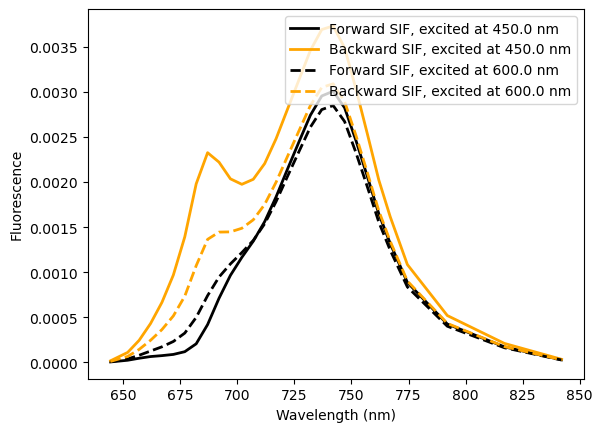

In [10]:
# Plot some cross section in wle and wlf space:
figure()
plot(wl_set.wlf,leaf.Mf[:,ind_wle_blue], color=:black, lw = 2 , label="Forward SIF, excited at $wl_blue nm")
plot(wl_set.wlf,leaf.Mb[:,ind_wle_blue],color=:orange, lw = 2 , label="Backward SIF, excited at $wl_blue nm" )
plot(wl_set.wlf,leaf.Mf[:,ind_wle_red], color=:black,ls="--",lw=2, label="Forward SIF, excited at $wl_red nm" )
plot(wl_set.wlf,leaf.Mb[:,ind_wle_red], color=:orange,ls="--",lw=2, label="Backward SIF, excited at $wl_red nm" )
xlabel("Wavelength (nm)")
ylabel("Fluorescence")
legend()
gcf()

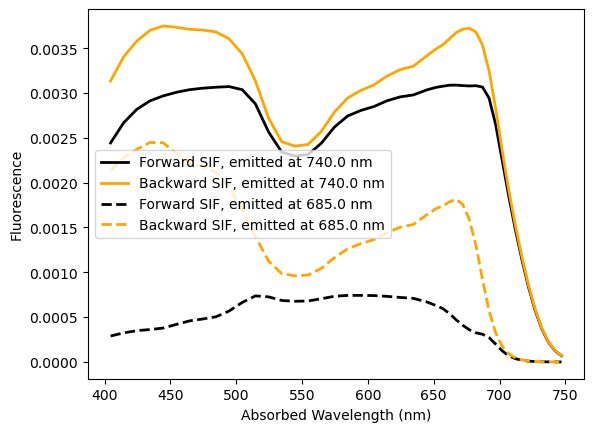

In [11]:
# Plot some cross section in wle and wlf space:
figure()
plot(wl_set.wle,leaf.Mf[ind_wlf_FR,:], color=:black, lw = 2 , label="Forward SIF, emitted at $wl_FarRed nm")
plot(wl_set.wle,leaf.Mb[ind_wlf_FR,:],color=:orange, lw = 2 , label="Backward SIF, emitted at $wl_FarRed nm" )
plot(wl_set.wle,leaf.Mf[ind_wlf_R,:], color=:black,ls="--",lw=2, label="Forward SIF, emitted at $wl_Red nm" )
plot(wl_set.wle,leaf.Mb[ind_wlf_R,:], color=:orange,ls="--",lw=2, label="Backward SIF, emitted at $wl_Red nm" )
xlabel("Absorbed Wavelength (nm)")
ylabel("Fluorescence")
legend()
gcf()

---
### Leaf reflectance and transmission
Within Fluspect, leaf reflectance and transmission is calculated (this part is actually identical to what PROSPECT is doing and much less involved than the Fluorescence part). The model basically uses a doubling adding routine to solve for the radiative transfer within the leaf using constituent absorption cross sections and constituent abundances in the leaf (assuming vertically homogenous distribution).

Here, we just create another leaf with different concentrations to show the impact on leaf reflectance and transmission due to changes in chlorophyll content and liquid water content (mostly in the two liquid water absorption bands at 1400 and 1900nm).

In [12]:
# Let's create a leaf with a different Cab and Cw (water) content (<span style="color:red">Try changing other pigment contents, plot leaf reflectance and transmissions and explain where (spectrally) and why reflectance and transmission changes</span>):
leaf_2 = create_leaf_bio(FT, wl_set.nwl, wl_set.nWlE, wl_set.nWlF);
leaf_2.Cab = 80
leaf_2.Cw = 0.012
# show leaf Chlorophyll content:
# and Run Fluspect:
fluspect!(leaf_2, wl_set);

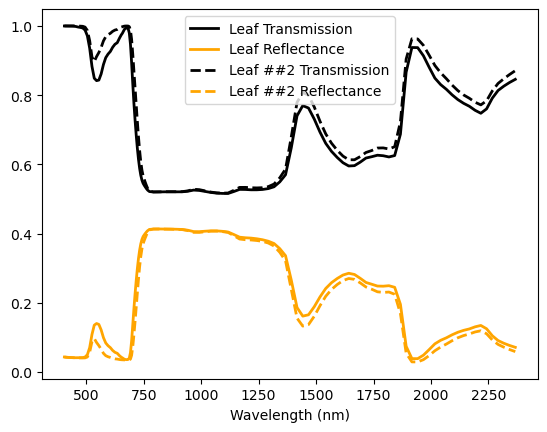

In [13]:
figure()
plot(wl_set.wl,1 .-leaf.τ_SW, color=:black, lw = 2 , label="Leaf Transmission")
plot(wl_set.wl,leaf.ρ_SW,color=:orange, lw = 2 , label="Leaf Reflectance" )
plot(wl_set.wl,1 .-leaf_2.τ_SW, color=:black, ls="--",lw=2, label="Leaf ##2 Transmission")
plot(wl_set.wl,leaf_2.ρ_SW,color=:orange, ls="--",lw=2, label="Leaf ##2 Reflectance" )
xlabel("Wavelength (nm)")
legend()
gcf()

---
## Moving from the leaf to the entire canopy

Our model here is based on mSCOPE[^1] and we can prescribe different leaf optical properties within a complex canopy. At the moment, the leaf angular distribution is the same vertically (but could be changed in the future).

[^1]: Yang, P., Verhoef, W. and van der Tol, C., 2017. The mSCOPE model: A simple adaptation to the SCOPE model to describe reflectance, fluorescence and photosynthesis of vertically heterogeneous canopies. Remote sensing of environment, 201, pp.1-11.

In [14]:
# This is to be changed later but at the moment, we need to generate an Array of leaves, basically for each layer of the canopy

arrayOfLeaves = [create_leaf_bio(FT, wl_set.nwl, wl_set.nWlE, wl_set.nWlF) for i in 1:canopy_rt.nlayers]
for i in 1:canopy_rt.nlayers
    fluspect!(arrayOfLeaves[i],  wl_set)
end

### Basic Steps for Canopy RT:
Below are the basic steps for the canopy radiative transfer (SIF fluxes are dependent on stress levels at each leaf but here we use a standard SIF yield for now):

In [15]:
# Set Soil albedo to 0.2
soil = SoilOpti{FT}(wl_set.wl, FT(0.2)*ones(FT, length(wl_set.wl)), FT[0.1], FT(290.0))
angles = SolarAngles{FT}()

# Compute Canopyoptical properties dependend on sun-sensor and leaf angle distributions:
compute_canopy_geometry!(canopy_rt, angles, canOpt_rt)
# Compute RT matrices with leaf reflectance and transmissions folded in:
compute_canopy_matrices!(arrayOfLeaves, canOpt_rt);
# Perform SW radiation transfer:
simulate_short_wave!(canopy_rt, canOpt_rt, canRad_rt, sunRad_rt, soil);
# Compute outgoing SIF flux (using constant fluorescence efficiency at the chloroplast level)
derive_canopy_fluxes!(canopy_rt, canOpt_rt, canRad_rt, sunRad_rt, soil, arrayOfLeaves, wl_set);

### Test a VZA dependence in the principal plane

In [16]:
SIF_FR = Float32[]
SIF_R = Float32[]
reflVIS = Float32[]
reflNIR = Float32[]

# Just running the code over all geometries:

# Set sun SZA to 30 degrees
angles.tts=30
# Set 0 azimuth (principal plane)
angles.psi=0
# LAI of 3:
canopy_rt.LAI = 3
# Define VZA
VZA=collect(-89.5:0.5:89.5)

for VZA_ in VZA
    angles.tto=VZA_
    compute_canopy_geometry!(canopy_rt, angles, canOpt_rt)
    compute_canopy_matrices!(arrayOfLeaves, canOpt_rt);
    simulate_short_wave!(canopy_rt, canOpt_rt, canRad_rt, sunRad_rt, soil);
    computeSIF_Fluxes!(arrayOfLeaves, canOpt_rt, canRad_rt, canopy_rt, soil, wl_set);
    # Handpicked indices in
    push!(reflVIS, canRad_rt.alb_obs[ind_red])
    push!(reflNIR, canRad_rt.alb_obs[ind_NIR])
    push!(SIF_R , canRad_rt.SIF_obs[ind_wlf_R])
    push!(SIF_FR, canRad_rt.SIF_obs[ind_wlf_FR ])
end

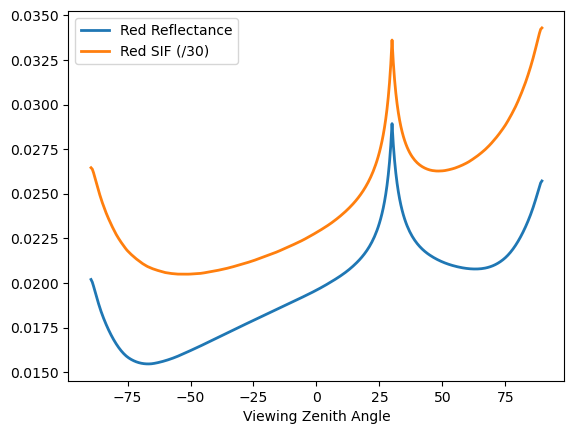

In [17]:
# Plots Visible
figure()
plot(VZA, reflVIS, label="Red Reflectance", lw=2)
plot(VZA, SIF_R/30, label="Red SIF (/30)", lw=2)
xlabel("Viewing Zenith Angle")
legend()
gcf()

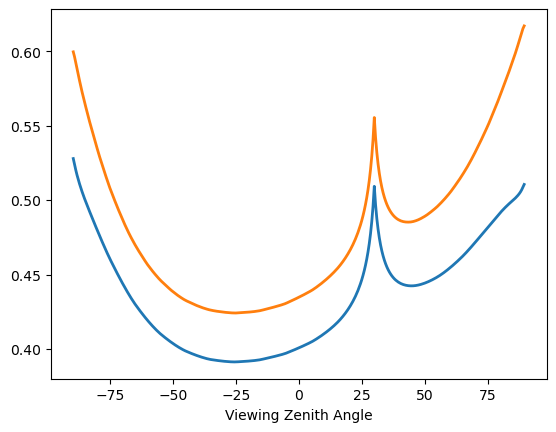

In [18]:
# Plot Near Infrared:
figure()
plot(VZA, reflNIR, label="NIR Reflectance", lw=2)
plot(VZA, SIF_FR/6, label="Far Red SIF (/6)", lw=2)
xlabel("Viewing Zenith Angle")
gcf()

---
## BRDF sampling
By going through viewing and azimuth angles, we can construct a full BRDF for reflectance and SIF emissions at different wavelengths:

In [19]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]
angles.tts=48
angles.psi=0
canopy_rt.LAI=3.22
for psi=0:360
    angles.psi=psi
    for VZA=0:1:85
        angles.tto=VZA

        compute_canopy_geometry!(canopy_rt, angles, canOpt_rt)
        compute_canopy_matrices!(arrayOfLeaves, canOpt_rt);
        simulate_short_wave!(canopy_rt, canOpt_rt, canRad_rt, sunRad_rt, soil);
        computeSIF_Fluxes!(arrayOfLeaves, canOpt_rt, canRad_rt, canopy_rt, soil, wl_set);
        push!(reflVIS, canRad_rt.alb_obs[28])
        push!(reflNIR, canRad_rt.alb_obs[52])
        push!(SIF_R , canRad_rt.SIF_obs[8])
        push!(SIF_FR, canRad_rt.SIF_obs[20])
    end
end

In [20]:
A = reshape(reflNIR, ( 86,361));
B = reshape(reflVIS, ( 86,361));
SIFFER = reshape(SIF_R, ( 86,361));
SIFFER_FR = reshape(SIF_FR, ( 86,361));

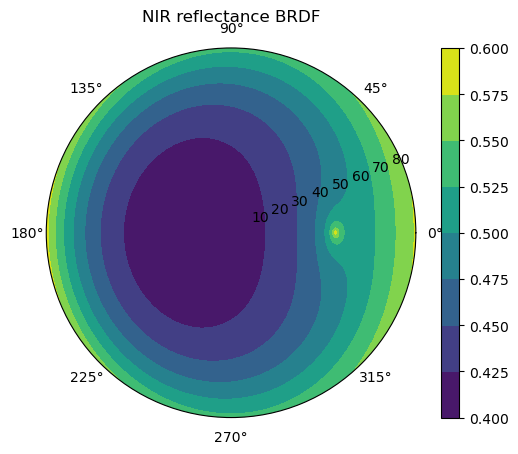

In [21]:
##heatmap(A, cmap=)
figure()
subplot(1,1,1, polar=true)
grid(false)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  A,  cmap=:viridis)
title("NIR reflectance BRDF")
colorbar()
gcf()

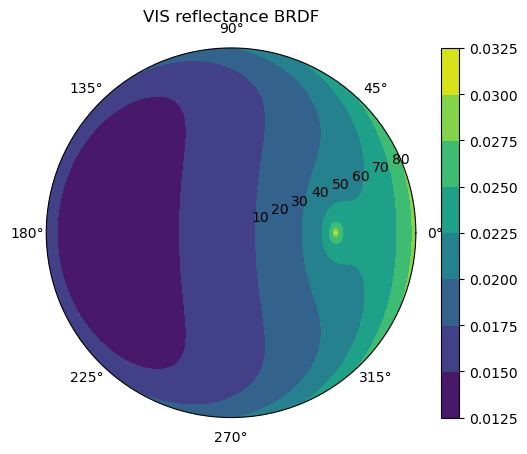

In [22]:
##heatmap(A, cmap=)
figure()
subplot(1,1,1, polar=true)
grid(false)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  B,  cmap=:viridis)
title("VIS reflectance BRDF")
colorbar()
gcf()

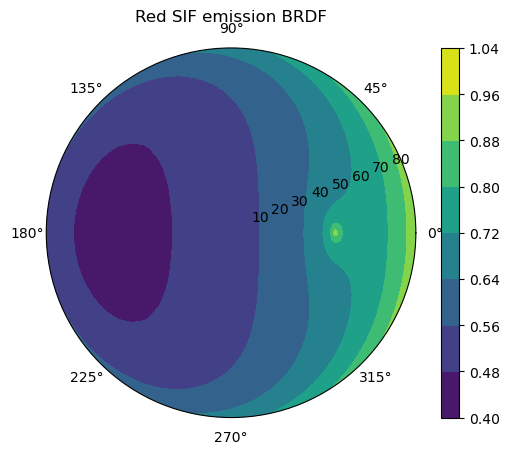

In [23]:
figure()
subplot(1,1,1, polar=true)
grid(false)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER, cmap=:viridis)
title("Red SIF emission BRDF")
colorbar()
gcf()

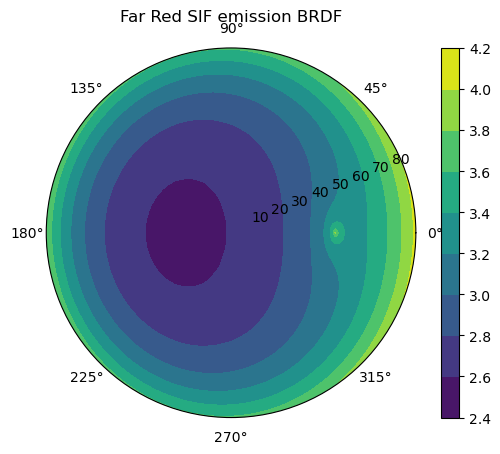

In [24]:
figure()
subplot(1,1,1, polar=true)
grid(false)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER_FR, cmap=:viridis)
title("Far Red SIF emission BRDF")
colorbar()
gcf()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*